# Expression Level of DEGs in 24h dNipBL mESCs and proximity to ChIP features

***Purpose:*** Plotting distance from promoter of DEGs to ChIP signal to see relationship between proximity of the chromatin-interacting proteins and differential expression.

* Cumulative portion of genes relative to TSS
* Concentration of CTCF peaks within a TAD compared to DEGs

In [1]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load data and project files

- dNipbL dataset 
- ChIP .bed files

In [3]:
day1_res_df = flt.load_tss_df()
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [4]:
day1_res_df.head(5)

,gene_id,chrom,start,end,strand,tss,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_vst_counts,DE_status
21,ENSMUSG00000102269.1,chr1,4522904,4522904,+,4522904,ENSMUSG00000102269.1,NaN,NaN,NaN,NaN,6.282923,nonsig
26,ENSMUSG00000098104.1,chr1,4689404,4689404,-,4689404,ENSMUSG00000098104.1,NaN,NaN,NaN,NaN,6.275598,nonsig
30,ENSMUSG00000103922.1,chr1,4771130,4771130,+,4771130,ENSMUSG00000103922.1,NaN,NaN,NaN,NaN,8.387261,nonsig
31,ENSMUSG00000033845.13,chr1,4785711,4785711,-,4785711,ENSMUSG00000033845.13,NaN,NaN,NaN,NaN,12.092018,nonsig
32,ENSMUSG00000102275.1,chr1,4779213,4779213,-,4779213,ENSMUSG00000102275.1,NaN,NaN,NaN,NaN,6.991153,nonsig


In [5]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

### Annotate distance to ChIP peak



In [6]:
# # Annotate df with distance to each peak
# for (chip, file) in chip_peaks_condition_dict.items():
#     peaks = flt.get_peak_bioframe(file)
#     day1_res_df = flt.label_closest_peak(day1_res_df, peaks, chip)

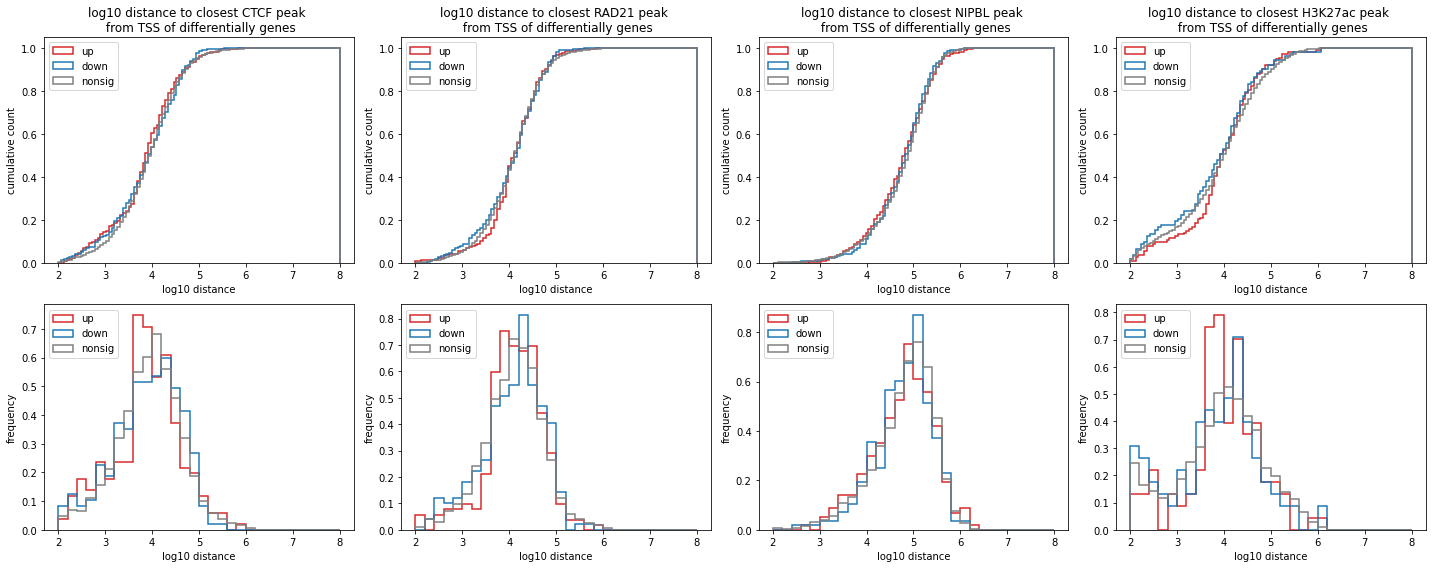

In [7]:

# Annotate df with distance to each peak
for (chip, file) in chip_peaks_condition_dict.items():
    peaks = flt.get_peak_bioframe(file)
    day1_res_df = flt.label_closest_peak(day1_res_df, peaks, chip)
    
    
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(20, 8))

for (chip_name, file), axi in zip(chip_peaks_condition_dict.items(), np.arange(axs.shape[1])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 chip_name+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS of differentially genes'.format(chip_name))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                chip_name+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

# Concentration of CTCF within TADs of DEG

In [8]:
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

In [9]:
# Break up the categories into quantiles according ot vst_counts
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts")
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='down')

# set counts threshold to 6.0
cutoff = 6.0
cut = (quantiled_df['avg_vst_counts'] > cutoff)
quantiled_df = quantiled_df[cut]

In [10]:
category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

category_colormap_degs = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',
                        }

In [11]:
day1_res_df.head(3)

,gene_id,chrom,start,end,strand,tss,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_vst_counts,DE_status,CTCF_distance,RAD21_distance,NIPBL_distance,H3K27ac_distance
21,ENSMUSG00000102269.1,chr1,4522904,4522904,+,4522904,ENSMUSG00000102269.1,NaN,NaN,NaN,NaN,6.282923,nonsig,31522,31489,143882,121450
26,ENSMUSG00000098104.1,chr1,4689404,4689404,-,4689404,ENSMUSG00000098104.1,NaN,NaN,NaN,NaN,6.275598,nonsig,2419,2283,11944,104
30,ENSMUSG00000103922.1,chr1,4771130,4771130,+,4771130,ENSMUSG00000103922.1,NaN,NaN,NaN,NaN,8.387261,nonsig,17771,25098,100508,0


maximum is: up
5
maximum is: down
6
maximum is: nonsig
76
[ 0 10 20 30 40 50 60 70]
8
RangeIndex(start=0, stop=8, step=1)
[ 0 10 20 30 40 50 60 70]
8
RangeIndex(start=0, stop=8, step=1)
[ 0 10 20 30 40 50 60 70]
8
RangeIndex(start=0, stop=8, step=1)


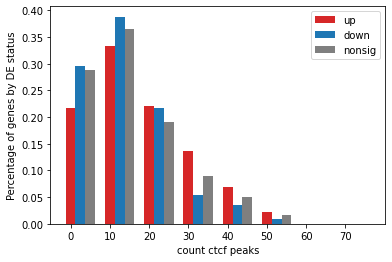

In [26]:
# def distribution_features_by_region(
#     region_df,
#     feature_df,
#     region_group_col='num_enhancers',
#     feature_agg_key='DE_status',
#     feature_name='genes',
#     feature_category_colors={"up": 'tab:red', 
#                              "down": 'tab:blue',
#                              "nonsig": 'tab:grey'},
#     ax=None,
#     plot_title=None
# ):
#     """
#     Plots bar graph of the percentage features that overlap with the intervals
#     in region_df. The x axis is categories of regions defined by region_df[region_group_col]
#     and y axis is number of features, grouped by category labels in feature_df[feature_agg_key].
    
#     Parameters:
#     -----------
#     region_df: bioframe df with one interval (chr, start, end) for regions.
#     feature_df: bioframe df with one interval (chr, start, end) for features (e.g. genes)
#     region_group_col: column in region_df with categories of the regions.
#     feature_agg_key: column in feature_df that has category labels for aggregation.
#     feature_category_colors: categories in feature_df[feature_agg_key] and colors for plotting.
    
#     Returns:
#     --------
#     bar plot
#     """ 

# todo: wrap finding first overlaps of features within region in another func

# second step (already in function): counting/aggregating another feature according to ^^ categorizing the regions

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

region_df = df
feature_df = day1_res_df
region_group_col='count_ctcf_peaks'
feature_agg_key='DE_status'
feature_name='genes'
feature_category_colors={"up": 'tab:red', 
                            "down": 'tab:blue',
                            "nonsig": 'tab:grey'}
bin_size=10

ax = plt.subplot()

groups = pd.DataFrame()
bar_size = 1/(len(feature_category_colors) + 1)
x_pos = 0
max_count_val = 0
for cat, _ in feature_category_colors.items():

    cat_ix = np.where(feature_df[feature_agg_key] == cat)
    
    if feature_df.iloc[cat_ix].shape[0] < 1:
        warnings.warn(
            (
            "category {} is empty, skipped in plotting".
                format(cat)
            )
        )
        continue

    region_df[cat+'_counts'] = bf.count_overlaps(region_df, feature_df.iloc[cat_ix])['count']

    if max(region_df[cat+'_counts']) > max_count_val:
        print('maximum is: '+cat)
        print(max(region_df[cat+'_counts']))
        max_count_val = max(region_df[cat+'_counts'])

        
# create x-axis values, where each bin is [a, b)
bins = np.arange(0, max_count_val+1, bin_size)

for cat, color in feature_category_colors.items():

    counts = []
    for i in bins:
        counts.append(region_df.groupby(region_group_col).sum([cat+'_counts'])[cat+'_counts'][i:i+bin_size].sum())

    groups[cat] = counts


    perc = groups[cat]/groups[cat].sum()

    print(bins)
    print(len(bins))
    print(groups.index)
    ax.bar(groups.index + x_pos, perc, width=bar_size, color=color, label=cat)
    x_pos += bar_size
        
    # todo: collect values for plotting in a nice for loop :) 
    # - find/save max across each category during the first loop
    # - create array to plot for each category
    # - fill array with aggregated counts, depending on bin (make an option for bin to simply be itself)

#     perc = groups[cat]/groups[cat].sum()

#     ax.bar(groups.index + x_pos, perc, width=bar_size, color=col, label=cat)
#     x_pos += bar_size
    
ax.set(
    xticks=groups.index,
    xticklabels=bins,
    xlabel=' '.join(region_group_col.split('_')),
    ylabel='Percentage of {} by {}'.format(feature_name,
                                            ' '.join(feature_agg_key.split('_')))
)
ax.legend()

# if plot_title != None:
#     ax.set_title(plot_title)

In [81]:
bin_range = np.arange(0, 65+1, 5)

In [90]:

pd.cut(region_df.down_counts, bins=bin_range, include_lowest=True)

0       (-0.001, 5.0]
1       (-0.001, 5.0]
2       (-0.001, 5.0]
3       (-0.001, 5.0]
4       (-0.001, 5.0]
            ...      
4714    (-0.001, 5.0]
4715    (-0.001, 5.0]
4716    (-0.001, 5.0]
4717    (-0.001, 5.0]
4718    (-0.001, 5.0]
Name: down_counts, Length: 4719, dtype: category
Categories (13, interval[float64, right]): [(-0.001, 5.0] < (5.0, 10.0] < (10.0, 15.0] < (15.0, 20.0] ... (45.0, 50.0] < (50.0, 55.0] < (55.0, 60.0] < (60.0, 65.0]]

In [85]:
region_df.head()

,chrom,start,end,count_ctcf_peaks,up_counts,down_counts,nonsig_counts
0,chr1,0,3675000,0,0,0,0
1,chr1,3675001,4405000,3,0,0,0
2,chr1,4405001,4775000,5,0,0,3
3,chr1,4775001,5155000,5,0,1,6
4,chr1,5155001,5905000,2,0,0,0


In [80]:
region_df.groupby(region_group_col).sum([cat+'_counts'])[cat+'_counts'][50:60].sum()

19

In [79]:
region_df.groupby([region_group_col, pd.cut(region_df[cat+'_counts'], bins=13)]).sum()

start          end  up_counts  \
count_ctcf_peaks up_counts                                              
0                (-0.005, 0.385]  12380705217  12504902639          0   
                 (0.385, 0.769]             0            0          0   
                 (0.769, 1.154]     110560002    112330000          2   
                 (1.154, 1.538]             0            0          0   
                 (1.538, 1.923]             0            0          0   
...                                       ...          ...        ...   
65               (3.077, 3.462]             0            0          0   
                 (3.462, 3.846]             0            0          0   
                 (3.846, 4.231]             0            0          0   
                 (4.231, 4.615]             0            0          0   
                 (4.615, 5.0]               0            0          0   

                                  down_counts  nonsig_counts  
count_ctcf_peaks up_counts                                    
0                (-0.005, 0.385]            1            104  
                 (0.385, 0.769]             0              0  
                 (0.769, 1.154]             0              0  
                 (1.154, 1.538]             0              0  
                 (1.538, 1.923]             0              0  
...                                       ...            ...  
65               (3.077, 3.462]             0              0  
                 (3.462, 3.846]             0              0  
                 (3.846, 4.231]             0              0  
                 (4.231, 4.615]             0              0  
                 (4.615, 5.0]               0              0  

[728 rows x 5 columns]

In [50]:
region_df[region_df['nonsig_counts'] == 76]

,chrom,start,end,count_ctcf_peaks,up_counts,down_counts,nonsig_counts
1321,chr4,145395001,148085000,12,0,0,76


In [45]:
count_vals = groups.index.values
pd.cut(count_vals, bins=13, retbins=True)

([(-0.065, 5.0], (-0.065, 5.0], (-0.065, 5.0], (-0.065, 5.0], (-0.065, 5.0], ..., (55.0, 60.0], (55.0, 60.0], (55.0, 60.0], (60.0, 65.0], (60.0, 65.0]]
 Length: 56
 Categories (13, interval[float64, right]): [(-0.065, 5.0] < (5.0, 10.0] < (10.0, 15.0] < (15.0, 20.0] ... (45.0, 50.0] < (50.0, 55.0] < (55.0, 60.0] < (60.0, 65.0]],
 array([-0.065,  5.   , 10.   , 15.   , 20.   , 25.   , 30.   , 35.   ,
        40.   , 45.   , 50.   , 55.   , 60.   , 65.   ]))

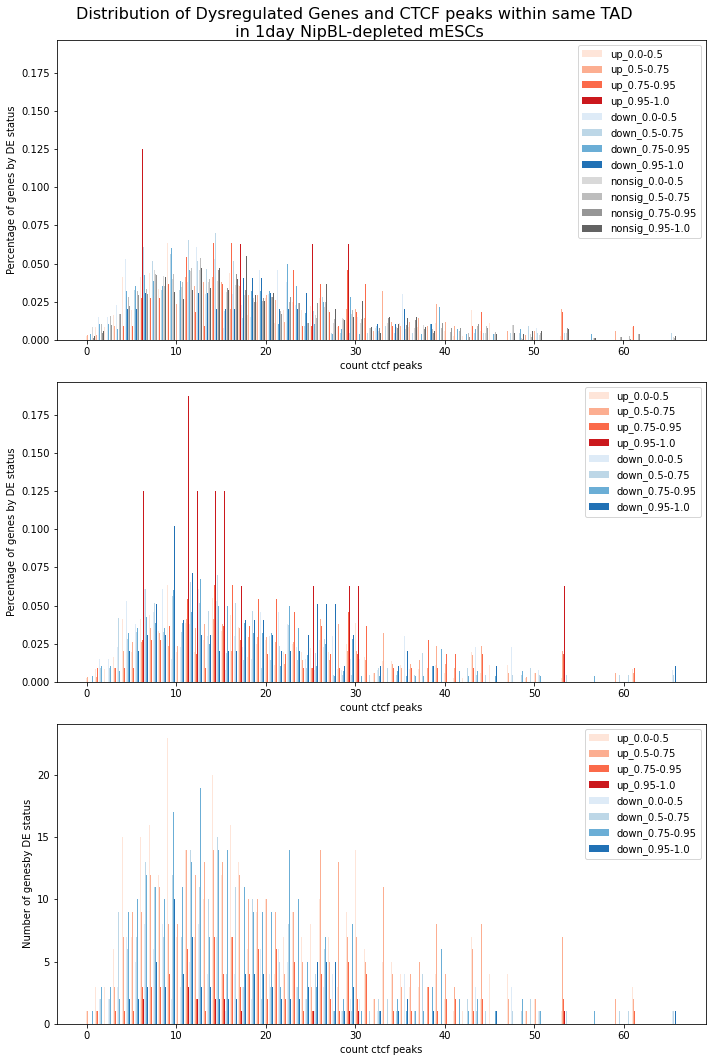

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# Annotate number of CTCF within the tad
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_big,
                                    region_group_col='count_ctcf_peaks',
                                    ax=axs[0]
                                   )

pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_degs,
                                    region_group_col='count_ctcf_peaks',
                                    ax=axs[1]
                                   )

pfn.group_features_by_region(df,
                             quantiled_df,
                             feature_category_colors=category_colormap_degs,
                             region_group_col='count_ctcf_peaks',
                             ax=axs[2]
                            )
    
plt.tight_layout()
plt.show()

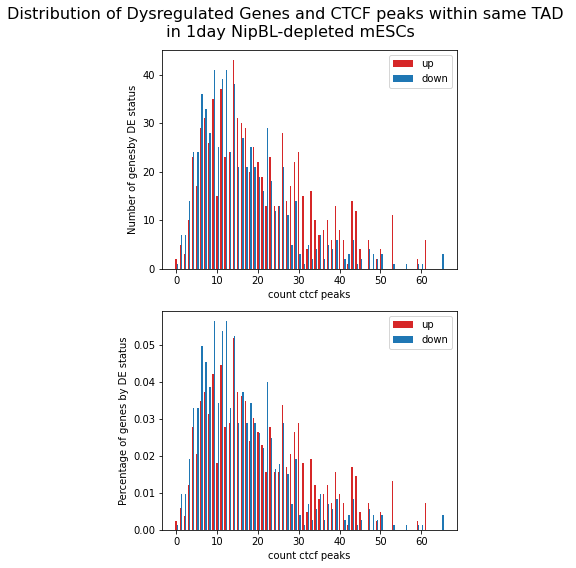

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# Annotate number of CTCF within the tad
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

pfn.group_features_by_region(df,
                             day1_res_df,
                             region_group_col='count_ctcf_peaks',
                             feature_category_colors={"up": 'tab:red', 
                                    "down": 'tab:blue'},
                             ax=axs[0]
                            )

pfn.distribution_features_by_region(df,
                             day1_res_df,
                             region_group_col='count_ctcf_peaks',
                             feature_category_colors={"up": 'tab:red', 
                                    "down": 'tab:blue'},
                             ax=axs[1]
                            )

    
plt.tight_layout()
plt.show()

Grouping into bins to see a little better :D 

In [15]:
# Assign bins for ctcf counts to group them
df = pfn.assign_bin(df, 'count_ctcf_peaks', np.arange(0, 70, 5), 'count_ctcf_bin')


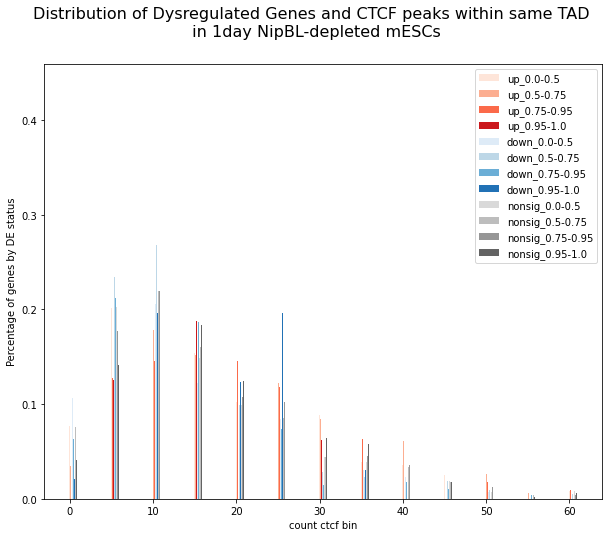

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# plot
pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_big,
                                    region_group_col='count_ctcf_bin',
                                    ax=axs
                                   )

In [40]:
day1_res_df['count_ctcf_within_tad'].isna().sum()

8381

In [17]:
# Add column to gene df with the count of ctcfs
day1_res_df['count_ctcf_within_tad'] = bf.overlap(day1_res_df, df, how='inner', suffixes=('_genes', '_tads'))['count_ctcf_peaks_tads']

quantiled_df['count_ctcf_within_tad'] = bf.overlap(quantiled_df, df, how='inner', suffixes=('_genes', '_tads'))['count_ctcf_peaks_tads']


In [18]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py'>

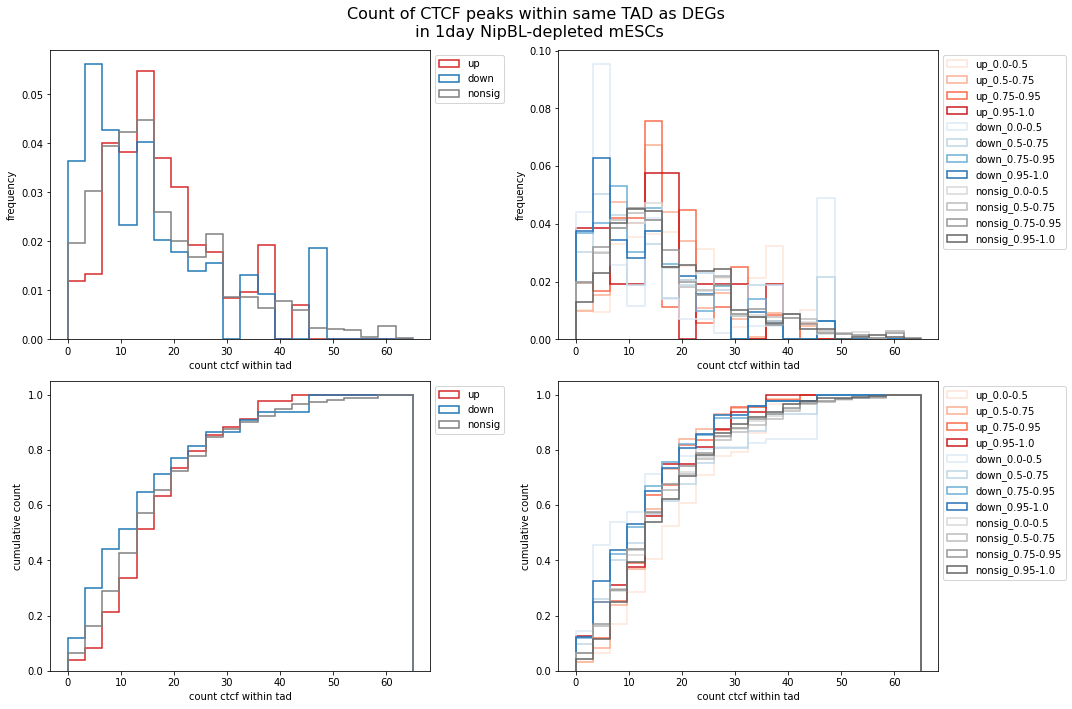

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(('Count of CTCF peaks within same TAD as DEGs'
             '\n in 1day NipBL-depleted mESCs'),
             fontsize=16)

pfn.plot_count_histogram(day1_res_df,
                     'count_ctcf_within_tad',
                    cumulative=True,
                     bins=20,
                    ax=axs[1, 0])

pfn.plot_count_histogram(day1_res_df,
                     'count_ctcf_within_tad',
                    cumulative=False,
                    bins=20,
                    ax=axs[0, 0])

pfn.plot_count_histogram(quantiled_df,
                     'count_ctcf_within_tad',
                     category_colors=category_colormap_big,
                    cumulative=True,
                     bins=20,
                    ax=axs[1, 1])

pfn.plot_count_histogram(quantiled_df,
                     'count_ctcf_within_tad',
                     category_colors=category_colormap_big,
                     cumulative=False,
                     bins=20,
                     ax=axs[0, 1])

plt.tight_layout()
plt.show()

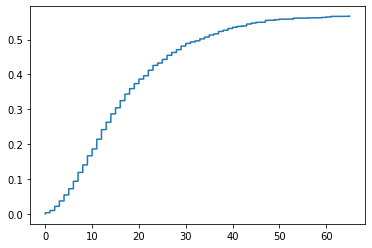

In [32]:
plt.plot(day1_res_df.sort_values(['count_ctcf_within_tad'])['count_ctcf_within_tad'].values, np.linspace(0, 1, len(day1_res_df)))



In [20]:
day1_res_df['DE_status'].value_counts()

nonsig    17791
up          831
down        727
Name: DE_status, dtype: int64

In [21]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      9180
nonsig_0.5-0.75     4281
nonsig_0.75-0.95    3476
nonsig_0.95-1.0      854
up_0.0-0.5           363
up_0.5-0.75          342
down_0.75-0.95       283
down_0.5-0.75        214
down_0.0-0.5         132
up_0.75-0.95         110
down_0.95-1.0         98
up_0.95-1.0           16
Name: DE_status, dtype: int64

In [22]:
quantiled_df[['status', 'quantile']] = quantiled_df['DE_status'].str.split('_', expand=True)

array([[<AxesSubplot:title={'center':'down'}>,
        <AxesSubplot:title={'center':'nonsig'}>],
       [<AxesSubplot:title={'center':'up'}>, <AxesSubplot:>]],
      dtype=object)

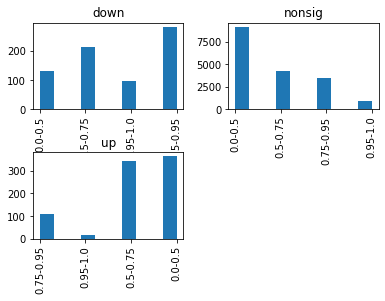

In [23]:
quantiled_df['quantile'].hist(by=quantiled_df['status'])